GENERAL IMPORTS AND SEED

In [0]:
import argparse
import torch
import torchvision
from torch import optim
from torchvision import transforms
import os
import os.path as osp
import random
import numpy as np
from pathlib import Path
from torch.utils.data import dataset
import PIL
from PIL import Image

# Fix the seed
seed = 1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(seed)
random.seed(seed)

ACCESS TO THE DRIVE FOLDER WHERE THE DATASET HAS BEEN STORED

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/2019_AIDL_TEAM4/colab_face_detection_siamesa/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


DEFINE ARGUMENTS

In [0]:
class Args:

    frontal_images_directories = "gdrive/My Drive/2019_AIDL_TEAM4/colab_face_detection_siamesa/dataset-cfp/Protocol/image_list_F.txt"
    profile_images_directories = "gdrive/My Drive/2019_AIDL_TEAM4/colab_face_detection_siamesa/dataset-cfp/Protocol/image_list_P.txt"
    split_main_directory = "gdrive/My Drive/2019_AIDL_TEAM4/colab_face_detection_siamesa/dataset-cfp/Protocol/Split"
    split_traindata = ["01", "02", "03", "04", "05", "06"]
    split_valdata = ["07", "08"]
    split_testdata = ["09", "10"]
    dataset_root = "gdrive/My Drive/2019_AIDL_TEAM4/colab_face_detection_siamesa"
    dataset= "CFPDataset"
    lr = float(1e-3)
    weight_decay = float(0.0005)
    momentum = float(0.9)
    betas = (0.9, 0.999)
    batch_size = int(14)
    workers = int(8)
    start_epoch = int(0)
    epochs = int(40)
    #save_every = int(2)
    pretrained = True
    siamese_linear = False
    data_aug = True
    resume = "checkpoint_e13_lr1e_3_40e_SGD"


DEFINE DATASET CLASS

In [0]:

class CFPDataset(dataset.Dataset):
    def __init__(self, path, args, img_transforms=None, dataset_root="",
                 split="train", input_size=(224, 224)):
        super().__init__()

        self.data = []
        self.split = split

        self.load(path, args)

        print("Dataset loaded")
        print("{0} samples in the {1} dataset".format(len(self.data),
                                                      self.split))
        self.transforms = img_transforms
        self.dataset_root = dataset_root
        self.input_size = input_size

    def load(self, path, args):

        # read directories for frontal images
        lines = open(args.frontal_images_directories).readlines()
        idx = 0
        directories_frontal_images = []
        #print(len(lines))
        while idx < len(lines):
            x = lines[idx].strip().split()
            directories_frontal_images.append(x)
            idx += 1
        #print(x)
        # read directories for profile images
        lines = open(args.profile_images_directories).readlines()
        idx = 0
        directories_profile_images = []
        #print(len(lines))
        while idx < len(lines):
            x = lines[idx].strip().split()
            directories_profile_images.append(x)
            idx += 1
        #print(x)
        # read same and different pairs of images and save at dictionary
        self.data = []
        for i in path:
            ff_diff_file = osp.join(args.split_main_directory, 'FF', i,
                                    'diff.txt')
            lines = open(ff_diff_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('ff_diff', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_frontal_images[int(img_pair[1])-1][1]
                pair_tag = 0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                #print(d)
                self.data.append(d)
                idx += 1

            ff_same_file = osp.join(args.split_main_directory, 'FF', i,
                                    'same.txt')
            lines = open(ff_same_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('ff_same', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_frontal_images[int(img_pair[1])-1][1]
                pair_tag = 1
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                #print(d)
                self.data.append(d)
                idx += 1

            fp_diff_file = osp.join(args.split_main_directory, 'FP', i,
                                    'diff.txt')
            lines = open(fp_diff_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('fp_diff', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_profile_images[int(img_pair[1])-1][1]
                pair_tag = 0
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                #print(d)
                self.data.append(d)
                idx += 1

            fp_same_file = osp.join(args.split_main_directory, 'FP', i,
                                    'same.txt')
            lines = open(fp_same_file).readlines()
            idx = 0
            while idx < int(len(lines)/1):
                img_pair = lines[idx].strip().split(',')
                #print('ff_same', img_pair)
                img1_dir = directories_frontal_images[int(img_pair[0])-1][1]
                img2_dir = directories_profile_images[int(img_pair[1])-1][1]
                pair_tag = 1
                d = {
                    "img1_path": img1_dir,
                    "img2_path": img2_dir,
                    "pair_tag": pair_tag
                }
                #print(d)
                self.data.append(d)
                idx += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        d = self.data[index]
        image1_path = osp.join(self.dataset_root, 'dataset-cfp', d[
            'img1_path'])
        image2_path = osp.join(self.dataset_root, 'dataset-cfp', d[
            'img2_path'])
        image1 = Image.open(image1_path).convert('RGB')
        image2 = Image.open(image2_path).convert('RGB')
        tag = d['pair_tag']
        if self.transforms is not None:
            # this converts from (HxWxC) to (CxHxW) as wel
            img1 = self.transforms(image1)
            img2 = self. transforms(image2)

        return img1, img2, tag

DEFINE DATA LOADER

In [0]:
from torch.utils import data

def get_dataloader(datapath, args, img_transforms=None, split="train"):

    if split == 'train':
        shuffle = True
        drop_last = True
    else:
        shuffle = False
        drop_last = False
    
    dataset = CFPDataset(datapath,
                         args,
                         split=split,
                         img_transforms=img_transforms,
                         dataset_root=osp.expanduser(args.dataset_root))
    
    data_loader = data.DataLoader(dataset,
                                  batch_size=args.batch_size,
                                  shuffle=shuffle,    
                                  num_workers=args.workers,
                                  pin_memory=True,
                                  drop_last=drop_last)
    return data_loader

DEFINE MODEL

In [0]:

import torch
from torch import nn
from torchvision.models import vgg16_bn


class SiameseDecision(nn.Module):
    """
    Siamese network. Siamese_linear = False.
    """
    def __init__(self, pretrained=False):
        super().__init__()

        self.feat = vgg16_bn(pretrained=pretrained).features

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=512*7*7*2, out_features=4096),
            nn.ReLU(True),
            nn.Dropout()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=2) ,
        )

    def forward(self, img1, img2):
        # the input to the vgg16 is a fixed-size 224x224 RGB image
        # we get the vgg16 features
        feat_1 = self.feat(img1)
        feat_2 = self.feat(img2)
        feat_1 = feat_1.view(feat_1.size(0), -1)
        feat_2 = feat_2.view(feat_2.size(0), -1)
        # we concatenate the two tensors of features
        feat = torch.cat((feat_1, feat_2), 1)
        # we run the classifier
        feat_3 = self.fc1(feat)
        tag = self.fc2(feat_3)
        return tag

class SiameseLinearDecision(nn.Module):
    """
    Siamese network. Siamese_linear = True.
    """
    def __init__(self, pretrained=False):
        super().__init__()

        self.feat = vgg16_bn(pretrained=pretrained).features
        
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(True),
            nn.Dropout()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=4096*2, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=2) ,
        )

    def forward(self, img1, img2):
        feat_1 = self.feat(img1)
        feat_2 = self.feat(img2)
        feat_1 = feat_1.view(feat_1.size(0), -1)
        feat_2 = feat_2.view(feat_2.size(0), -1)
        feat_1 = self.fc1(feat_1)
        feat_2 = self.fc1(feat_2)
       
        feat = torch.cat((feat_1, feat_2), 1)
        tag = self.fc2(feat)
        
        return tag


DEFINE LOSS

In [0]:
from torch import nn

class RecognitionCriterion(nn.Module):
    def __init__(self):
        super().__init__()
        self.classification_criterion = nn.CrossEntropyLoss()
        self.cls_loss = None

    def forward(self, *input):
        self.cls_loss = self.classification_criterion(*input)
        return self.cls_loss

DEFINE TRAINING AND VALIDATION FUNCTIONS

In [0]:
import torch
from torchvision import transforms
from torch.nn import functional as nnfunc
import numpy as np

def accuracy(predictions, y):
    correct = 0
    total = 0

    preds = torch.topk(predictions, k=1)
    for p, i, label in zip(preds[0], preds[1], y):
        #print(p, i, label)
        total += 1
        if i == 1 and label == 1:
            correct += 1
        if i == 0 and label == 0:
            correct += 1
    return correct/total

def train(model, loss_fn, optimizer, dataloader, epoch, device):
    model.train()
    all_loss = []
    all_acc = []
        
    for idx, (img1, img2, prob) in enumerate(dataloader):
        x1 = img1.float().to(device)
        x2 = img2.float().to(device)
        optimizer.zero_grad()
        prob_t = prob.to(torch.long)
        #prob_t = prob.type(torch.FloatTensor)
        prob_var = prob_t.to(device)
        #prob_var = prob.to(device)
        #prob_var = prob_var.unsqueeze(dim=1)
        #print(prob_var.size())
        #print(prob_var)
        
        output = model(x1, x2)
        #output = output.reshape(1, -1)
        #output = output.squeeze()
        #print(output.size())
        #print(output)
        
        loss = loss_fn(output, prob_var)
        all_loss.append(np.round(loss.item(), 5))
        acc = accuracy(output, prob_var)
        all_acc.append(np.round(acc, 4))
        
        loss.backward()
        optimizer.step()
        
            
        if idx % 100 == 0:
            message1 = "TRAIN Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            message2 = "Loss: [{0:.4f}]; Accuracy: [{1}]".format(loss.item(),
                                                                acc)
            print(message1, message2)
        torch.cuda.empty_cache()
    return all_loss, all_acc

def val(model, loss_fn, dataloader, epoch, device):
    model.eval()
    all_loss = []
    all_acc =[]
    
    for idx, (img1, img2, prob) in enumerate(dataloader):
        x1 = img1.float().to(device)
        x2 = img2.float().to(device)
        
        prob_t = prob.to(torch.long)
        #prob_t = prob.type(torch.FloatTensor)
        prob_var = prob_t.to(device)
        # prob_var = prob.to(device)
        #prob_var = prob_var.unsqueeze(dim=1)
        #print(prob_var.size())
        #print(prob_var)
        output = model(x1, x2)
        #output = output.reshape(1, -1)
        #output = output.squeeze()
        #print(output.size())
        #print(output)
        loss = loss_fn(output, prob_var)
        all_loss.append(np.round(loss.item(), 5))
        acc = accuracy(output, prob_var)
        all_acc.append(np.round(acc, 4))
                
        #print_state(idx, epoch, len(dataloader), loss_fn.cls_loss, split="val")
        if idx % 100 == 0:
            message1 = "VAL Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            message2 = "Loss: [{0:.4f}]; Accuracy: [{1}]".format(loss.item(), acc)
            print(message1, message2)
        torch.cuda.empty_cache()
    return all_loss, all_acc
  
def test(model, loss_fn, dataloader, epoch, device):
    model.eval()
    all_acc =[]
    
    for idx, (img1, img2, prob) in enumerate(dataloader):
        x1 = img1.float().to(device)
        x2 = img2.float().to(device)

        prob_t = prob.to(torch.long)
        #prob_t = prob.type(torch.FloatTensor)
        prob_var = prob_t.to(device)
        # prob_var = prob.to(device)
        #prob_var = prob_var.unsqueeze(dim=1)
        #print(prob_var.size())
        #print(prob_var)
        output = model(x1, x2)
        #output = output.reshape(1, -1)
        #output = output.squeeze()
        #print(output.size())
        #print(output)
        acc = accuracy(output, prob_var)
        all_acc.append(np.round(acc, 4))
        if idx % 100 == 0:
            message1 = "TEST Epoch [{0}]: [{1}/{2}] ".format(epoch, idx,
                                                              len(dataloader))
            message2 = "Accuracy: [{0:.4f}]".format(acc)
            print(message1, message2)
        torch.cuda.empty_cache()
    return all_acc

LOAD ARGUMENTS AND DEFINE IMAGE TRANSFORMATIONS

In [0]:
args = Args()

train_transform=None
if args.data_aug == False:
  img_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

else:
  img_transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                        transforms.RandomHorizontalFlip(), 
                                        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR), 
                                        transforms.ToTensor()])

    

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

LOAD DATASET SPLIT FOR TRAINING

In [0]:
train_loader = get_dataloader(args.split_traindata, args,
                              img_transforms=img_transforms)

Dataset loaded
8400 samples in the train dataset


LOAD DATASET SPLIT FOR VALIDATION

In [0]:
val_loader = get_dataloader(args.split_valdata, args,
                            img_transforms=val_transforms, split="val")

Dataset loaded
2800 samples in the val dataset


SPECIFY DEVICE

In [0]:
torch.cuda.is_available()

True

In [0]:
# check for CUDA
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

SELECT MODEL AND LOSS FUNCTION

In [0]:
if args.siamese_linear == False:
  print('SiameseDecision')
  model = SiameseDecision(pretrained=args.pretrained)
else:
  print('SiameseLinearDecision')
  model = SiameseLinearDecision(pretrained=args.pretrained)
model = model.to(device) 

loss_fn = RecognitionCriterion()

SiameseDecision


SPECIFY WEIGHTS DIRECTORY

In [0]:
# directory where we'll store model weights
weights_dir = "gdrive/My Drive/weights"
if not osp.exists(weights_dir):
  
    os.mkdir(weights_dir)

SELECT OPTIMIZER

In [0]:
#optimizer = torch.optim.Adam(model.parameters(), lr=args.lr,
#                             weight_decay=args.weight_decay)

optimizer = optim.SGD(model.parameters(), lr=args.lr,
                      momentum=args.momentum, weight_decay=args.weight_decay)

DEFINE CHECKPOINT

In [0]:

#afegir acc i loss i fer que guardi el millor epoch
def save_checkpoint(state, filename="checkpoint.pth", save_path=weights_dir):
    # check if the save directory exists
    if not Path(save_path).exists():
        Path(save_path).mkdir()

    save_path = Path(save_path, filename)
    torch.save(state, str(save_path))

RUN TRAIN

TRAIN Epoch [0]: [0/600]  Loss: [0.7035]; Accuracy: [0.35714285714285715]
TRAIN Epoch [0]: [100/600]  Loss: [0.7272]; Accuracy: [0.21428571428571427]
TRAIN Epoch [0]: [200/600]  Loss: [0.7092]; Accuracy: [0.35714285714285715]
TRAIN Epoch [0]: [300/600]  Loss: [0.7029]; Accuracy: [0.42857142857142855]
TRAIN Epoch [0]: [400/600]  Loss: [0.6878]; Accuracy: [0.42857142857142855]
TRAIN Epoch [0]: [500/600]  Loss: [0.6874]; Accuracy: [0.6428571428571429]
VAL Epoch [0]: [0/200]  Loss: [0.7718]; Accuracy: [0.0]
VAL Epoch [0]: [100/200]  Loss: [0.7672]; Accuracy: [0.0]
TRAIN Epoch [1]: [0/600]  Loss: [0.6744]; Accuracy: [0.5714285714285714]
TRAIN Epoch [1]: [100/600]  Loss: [0.6812]; Accuracy: [0.5714285714285714]
TRAIN Epoch [1]: [200/600]  Loss: [0.6831]; Accuracy: [0.6428571428571429]
TRAIN Epoch [1]: [300/600]  Loss: [0.7327]; Accuracy: [0.35714285714285715]
TRAIN Epoch [1]: [400/600]  Loss: [0.6982]; Accuracy: [0.35714285714285715]
TRAIN Epoch [1]: [500/600]  Loss: [0.6934]; Accuracy: [0.5

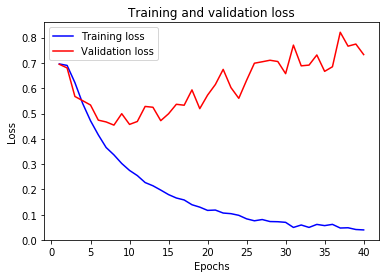

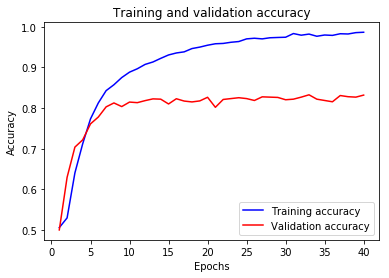

In [0]:
import matplotlib.pyplot as plt
# train and evalute for `epochs`
loss_epoch_train = []
loss_epoch_val = []
acc_epoch_train = []
acc_epoch_val = []

best_acc = -1
best_epoch = 0

for epoch in range(args.start_epoch, args.epochs):
    train_loss, train_acc = train(model, loss_fn, optimizer, train_loader, epoch, device=device)
    
    av_loss = np.mean(train_loss)
    av_acc = np.mean(train_acc)
    loss_epoch_train.append(av_loss)
    acc_epoch_train.append(av_acc)
  
  
    val_loss, val_acc = val(model, loss_fn, val_loader, epoch, device=device)
    
    av_loss = np.mean(val_loss)
    av_acc = np.mean(val_acc)
    loss_epoch_val.append(av_loss)
    acc_epoch_val.append(av_acc)
    
    if best_acc < av_acc:
        best_acc = av_acc
        best_epoch = epoch
        save_checkpoint({
            'epoch': epoch + 1,
            'batch_size': val_loader.batch_size,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()
         }, filename=str(args.resume)+".pth",
             save_path=weights_dir)
    
print("Best Epoch: ",best_epoch, "Best Acc: ", best_acc)
    
epochs = range(1, len(loss_epoch_train) + 1)
# b is for "solid blue line"
plt.plot(epochs, loss_epoch_train, 'b', label='Training loss')
# r is for "solid red line"
plt.plot(epochs, loss_epoch_val, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

epochs = range(1, len(acc_epoch_train) + 1)
# b is for "solid blue line"
plt.plot(epochs, acc_epoch_train, 'b', label='Training accuracy')
# r is for "solid red line"
plt.plot(epochs, acc_epoch_val, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

LOAD DATASET SPLIT FOR TEST

In [0]:
test_loader = get_dataloader(args.split_testdata, args,
                             img_transforms=val_transforms, split="test")

Dataset loaded
2800 samples in the test dataset


LOAD STORED WEIGHTS FOR BEST EPOCH

In [0]:
weights = osp.join(weights_dir,args.resume+'.pth')
epoch = 33
if args.resume:
    print(weights)
    checkpoint = torch.load(weights)
    model.load_state_dict(checkpoint['model'])
    #optimizer.load_state_dict(checkpoint['optimizer'])
    # Set the start epoch if it has not been
    if not args.start_epoch:
        args.start_epoch = checkpoint['epoch']

gdrive/My Drive/weights/checkpoint_e13_lr1e_3_40e_SGD.pth


RUN TEST

In [0]:
# Test

#veure que es carreguin els pessos
test_acc = test(model, loss_fn, test_loader, epoch, device=device)

av_acc = np.mean(test_acc)
print('Average test accuracy:', av_acc)

TEST Epoch [33]: [0/200]  Accuracy: [0.7857]
TEST Epoch [33]: [100/200]  Accuracy: [0.9286]
Average test accuracy: 0.8385710000000001
